# Description of Atoms module and analysis

# Table of contents
1. Creating Silicon Atoms class
2. Basic Atoms properties
3. Atoms class to_dict and from_dict methods
4. Making supercells
5. Spacegroup information and conventional structure
6. Making point-defect vacancy
7. Making surface structure
8. Making interfaces
9. Neighborhood analysis
10. X-ray diffractio (XRD) patterns
11. Obtaining machine-learning descriptors
12. Get an atomistic graph

In [ ]:
!pip install jarvis-tools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.2/809.2 kB 13.2 MB/s eta 0:00:00


### A crystal structure is defined by lattice-matrix, atomic coordinates and element types. As an example, let's create Siliocn crystal structure. We need to to import Atoms class from jarvis-tools to do that.

In [ ]:
# If you don't have jarvis-tools package installed, try
# !pip install jarvis-tools
# and restart runtime for your notebook
from jarvis.core.atoms import Atoms

In [ ]:
#Silicon crystal structure example. These crystal-structure data are generally obtained from XRD-type experiments.
box = [[2.715, 2.715, 0], [0, 2.715, 2.715], [2.715, 0, 2.715]]
coords = [[0, 0, 0], [0.25, 0.25, 0.25]]
elements = ["Si", "Si"]
Si = Atoms(lattice_mat=box, coords=coords, elements=elements)

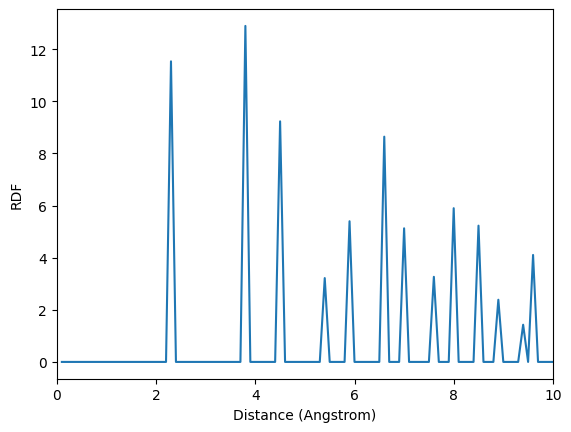

In [ ]:
# RDF
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
atoms=Si

dists=[]
for i in atoms.get_all_neighbors(r=10):
    for j in i:
      dists.append(j[2])
dists=np.array(dists)
hist, bins = np.histogram(dists, bins=np.arange(0.1, 10.2, 0.1))
number_density = atoms.num_atoms / atoms.volume
shell_vol = (
            4.0
            / 3.0
            * np.pi
            * (np.power(bins[1:], 3) - np.power(bins[:-1], 3))
        )

rdf = (
            hist / shell_vol / number_density / atoms.num_atoms
        )
plt.plot(bins[:-1], rdf)
plt.xlim([0,10])
plt.xlabel('Distance (Angstrom)')
plt.ylabel('RDF')
plt.show()

### Once the Atoms class is created, several properties can be calculated. Examples are given below:

In [ ]:
print ('volume',Si.volume)
print ('density in g/cm3', Si.density)
print ('composition as dictionary', Si.composition)
print ('Chemical formula', Si.composition.reduced_formula)
print ('Spacegroup info', Si.spacegroup())
print ('lattice-parameters', Si.lattice.abc, Si.lattice.angles)
print ('packing fraction',Si.packing_fraction)
print ('number of atoms',Si.num_atoms)
print ('Center of mass', Si.get_center_of_mass())
print ('Atomic number list', Si.atomic_numbers)

volume 40.02575174999999
density in g/cm3 2.3303545408113413
composition as dictionary OrderedDict([('Si', 2)])
Chemical formula Si
Spacegroup info Fd-3m (227)
lattice-parameters [3.83959, 3.83959, 3.83959] [60.0, 60.0, 60.0]
packing fraction 0.27858
number of atoms 2
Center of mass [0.67875 0.67875 0.67875]
Atomic number list [14, 14]


In [ ]:
# Print Atoms class in POSCAR format
print (Si)

Si2
1.0
2.715 2.715 0.0
0.0 2.715 2.715
2.715 0.0 2.715
Si
2
Cartesian
0.0 0.0 0.0
1.3575 1.3575 1.3575



### For databases purposes, it maybe important to store the Atoms class as a dictionary and then reloading the dictionary as Atoms object. An example is given below:

In [ ]:
Si.to_dict()

OrderedDict([('lattice_mat',
              [[2.715, 2.715, 0.0], [0.0, 2.715, 2.715], [2.715, 0.0, 2.715]]),
             ('coords', [[0.0, 0.0, 0.0], [0.25, 0.25, 0.25]]),
             ('elements', ['Si', 'Si']),
             ('abc', [3.83959, 3.83959, 3.83959]),
             ('angles', [60.0, 60.0, 60.0]),
             ('cartesian', False),
             ('props', ['', ''])])

In [ ]:
d = Si.to_dict()
new_atoms = Atoms.from_dict(d)

Making a supercells: there are two methods

In [ ]:
supercell_1 = Si.make_supercell([2,2,2])
supercell_2 = Si.make_supercell_matrix([[2,0,0],[0,2,0],[0,0,2]])
supercell_1.density == supercell_2.density

True

### Many tensor-like material properties such as elastic constants require conventional cell representations, which can be obtained as follows:

In [ ]:
from jarvis.analysis.structure.spacegroup import Spacegroup3D

spg = Spacegroup3D(Si)
Si_cvn = spg.conventional_standard_structure
print ('Number of atoms in the conventional cell', Si_cvn.num_atoms)
print ('Wycoff multoplicity in the primitive-cell', spg._dataset["wyckoffs"])

Number of atoms in the conventional cell 8
Wycoff multoplicity in the primitive-cell ['b', 'b']


In [ ]:
# Example to create Atoms object from POSCAR format file
from jarvis.io.vasp.inputs import Poscar
import urllib
url = 'https://raw.githubusercontent.com/usnistgov/jarvis/v2020.6.9/jarvis/examples/vasp/SiOptb88/POSCAR'
webf = urllib.request.urlopen(url)
txt = webf.read()
f = open('POSCAR', 'wb')
f.write(txt)
f.close()

pos = Poscar.from_file('POSCAR').atoms
print (pos)

Si2
1.0
3.348898 0.0 1.933487
1.116299 3.157372 1.933487
0.0 0.0 3.866975
Si
2
Cartesian
3.90705 2.7626987499999998 6.767215
0.55815 0.39467125 0.966745



### Realistic materials contain several types of point, line, surface and volume defects. Examples to create point-defects and surfaces are shown below:

In [ ]:
from jarvis.analysis.defects.vacancy import Vacancy

vacs = Vacancy(atoms=Si).generate_defects(enforce_c_size=10.0) #enforces cell-size to be close to 10 Angstroms
print (len(vacs), Atoms.from_dict(vacs[0].to_dict()["defect_structure"]).num_atoms)
# We find that there are only one unique point vacanc available based on Wycoff-position information

1 53


In [ ]:
from jarvis.analysis.defects.surface import wulff_normals, Surface

# Let's create (1,1,1) surface with three layers, and vacuum=18.0 Angstrom
# We center it around origin so that it looks good during visualization
surface_111 = Surface(atoms=Si, indices=[1, 1, 1], layers = 3, vacuum = 18 ).make_surface().center_around_origin()

In [ ]:
print (surface_111)

Si40
1.0
7.679179643685906 0.0 0.0
3.8395898218429525 6.650364651656329 0.0
0.0 0.0 33.67505980849834
Si
40
Cartesian
2.8796928117748335 -1.6625888370859176 10.959382571813123
2.8796926336177857 0.554194728476531 17.229406495212462
-0.9598975445392609 -1.6625934887422462 20.36441845691213
-0.9598977226963086 2.7709782940389776 23.499430418611794
-2.879692099146646 -2.770978294038978 10.175629581388206
4.799487722696308 1.6625934887422456 13.310641543087874
0.9598975445392608 -0.5541947284765302 16.445653504787543
-2.879692633617782 -2.770982945695306 19.58066546648721
-0.9598971882251685 2.7709829456953052 14.09439453351279
-2.8796928117748273 1.662588837085917 22.715677428186883
-2.8796922773036915 -0.5541947284765302 14.09439453351279
0.9598975445392618 -2.7709829456953052 17.229406495212462
0.9598973663822165 1.662588837085917 20.36441845691213
-2.8796928117748375 -0.5541993801328584 23.499430418611794
-0.9598970100681216 0.554199380132858 10.175629581388206
2.8796928117748335 -1.66

### For practical applications, materials are generally used as heterostructures. We can use the following as an example to make Si(111)-Si(111) interface

In [ ]:
from jarvis.analysis.interface.zur import ZSLGenerator, mismatch_strts, get_hetero,make_interface

film = Surface(atoms=Si, indices=[1, 1, 1], layers = 3, vacuum = 18 ).make_surface().center_around_origin()
substrate = Surface(atoms=Si, indices=[1, 1, 1], layers = 3, vacuum = 18 ).make_surface().center_around_origin()
info = make_interface(film=film, subs=substrate)['interface'].center(vacuum=18)

mismatch_u,mismatch_v 0.0 0.0


In [ ]:
info

Si80
1.0
7.67918 -0.0 -0.0
3.83959 -6.65036 -0.0
-0.0 -0.0 -65.6476016744472
Si
80
Cartesian
-2.879692811774834 1.6625888370859174 -39.48894538838912
-0.9598971882251709 2.7709829456953083 -48.110228283063215
-2.8796926336177857 -2.7709829456953075 -42.62395735008879
0.9598975445392615 -0.5541947284765293 -45.75896931178847
4.799487722696304 1.6625934887422462 -48.89398127348814
-2.8796920991466393 -2.7709782940389798 -52.0289932351878
-0.9598977226963069 2.7709782940389776 -38.705192397964204
-0.9598975445392604 -1.6625934887422456 -41.84020435966388
-2.879692277303693 -0.5541947284765285 -48.110228283063215
2.8796926336177835 0.5541947284765301 -44.97521632136355
0.9598975445392616 -2.770982945695306 -44.97521632136355
-4.799487722696308 -1.6625934887422456 -39.48894538838912
-0.9598975445392623 0.5541947284765302 -42.62395735008879
2.8796926336177857 2.770982945695306 -45.75896931178847
2.87969281177483 -1.6625888370859174 -48.89398127348814
-0.959897010068122 0.5541993801328556 -52

### Atomic-neighborhood analysis

In [ ]:
from jarvis.analysis.structure.neighbors import NeighborsAnalysis

nb = NeighborsAnalysis(Si)

In [ ]:
bins_rdf, rdf, nbs = nb.get_rdf() #Global Radial distribution function
adfa, bins_a = nb.ang_dist_first() #Angular distribution function upto first neighbor
adfb, bins_b = nb.ang_dist_second() #Angular distribution function upto second neighbor
ddf, bins_d = nb.get_ddf() #Dihedral distribution function upto first neighbor

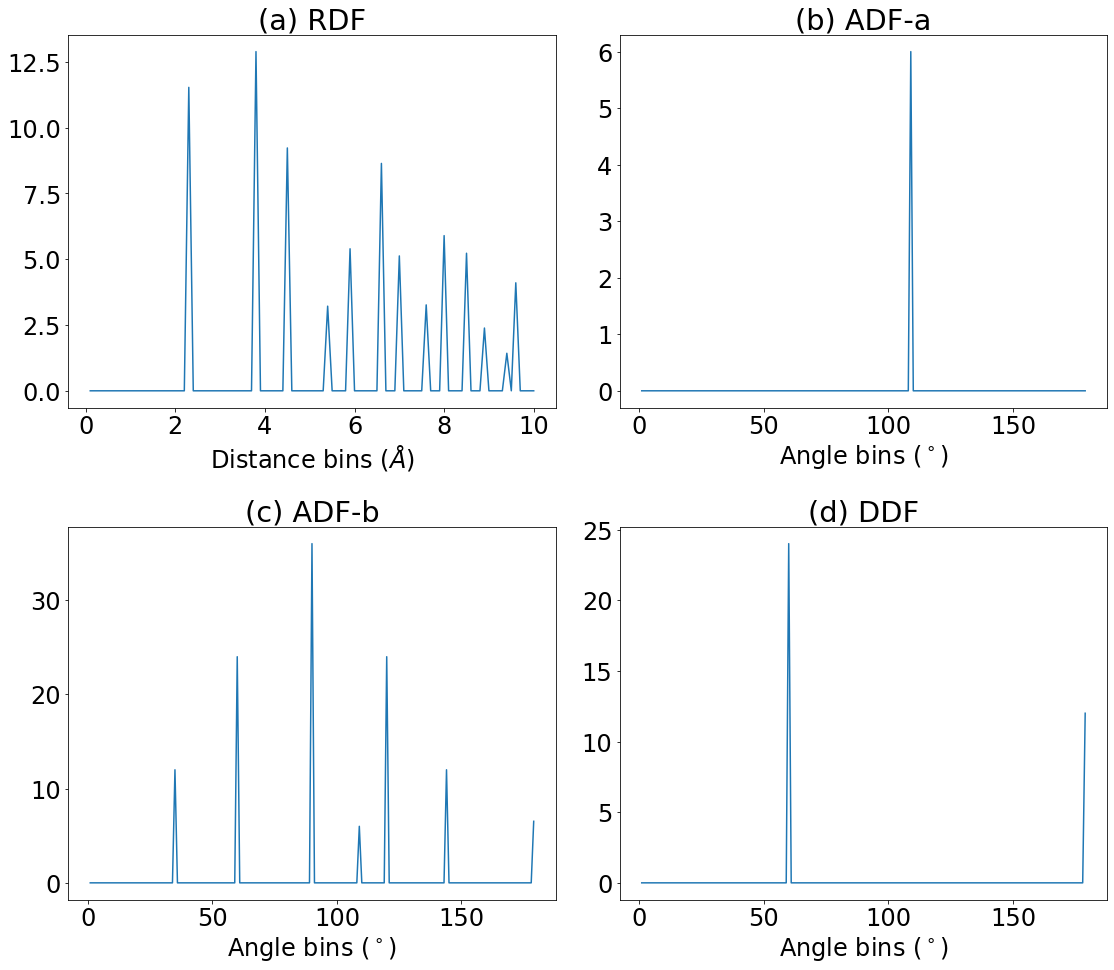

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

the_grid = GridSpec(2, 2)
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(16,14))

plt.subplot(the_grid[0, 0])
plt.title('(a) RDF')
plt.plot(bins_rdf, rdf)
plt.xlabel(r'Distance bins ($\AA$)')

plt.subplot(the_grid[0, 1])
plt.title('(b) ADF-a')
plt.plot(bins_a[:-1], adfa)
plt.xlabel(r'Angle bins ($^\circ$)')

plt.subplot(the_grid[1, 0])
plt.title('(c) ADF-b')
plt.plot(bins_b[:-1], adfb)
plt.xlabel(r'Angle bins ($^\circ$)')

plt.subplot(the_grid[1, 1])
plt.title('(d) DDF')
plt.plot(bins_d[:-1], ddf)
plt.xlabel(r'Angle bins ($^\circ$)')
plt.tight_layout()

### X-ray diffraction

In [ ]:
from jarvis.analysis.diffraction.xrd import XRD
theta,d_hkls,intens = XRD().simulate(atoms=Si)

<BarContainer object of 12 artists>

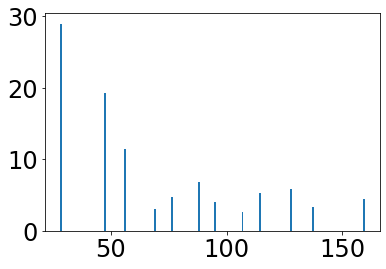

In [ ]:
plt.bar(theta,intens)

In [ ]:
from jarvis.core.spectrum import Spectrum
import numpy as np
def gaussian(theta2, alpha, fwhm):

    """
    Gaussian function for profiling peaks
    """

    tmp = ((alpha - theta2)/fwhm)**2
    return np.exp(-4*np.log(2)*tmp)

def get_profile(fwhm=0.1,min2theta=0,max2theta=180,res=0.02,two_thetas=[],intensities=[]):
    N = int((max2theta-min2theta)/res)
    px = np.linspace(min2theta, max2theta, N)
    py = np.zeros((N))
    for two_theta, intensity in zip(two_thetas, intensities):
        tmp = gaussian(two_theta, px, fwhm)
        py += intensity * tmp
    py /= np.max(py)
    return px,py

px,py=get_profile(two_thetas=theta,intensities=intens)

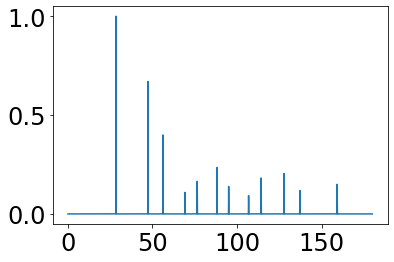

In [ ]:
plt.plot(px,py)

### Getting CFID descriptors: We can convert the chemo-physical information in the Atoms class to CFID features that can be used in Machine-learning

In [ ]:
from jarvis.ai.descriptors.cfid import CFID

cfid = CFID(Si)
feature_names = cfid.get_comp_descp(print_names=True)
feature_values = cfid.get_comp_descp().tolist()

In [ ]:
print (feature_names[0], feature_values[0], len(feature_names), len(feature_values) )

bp_mult_atom_rad 3490.3 1557 1557


Get an atomistic graph

In [ ]:
!pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 23.8 MB/s eta 0:00:00
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [ ]:
from jarvis.core.graphs import Graph
g,lg = Graph.atom_dgl_multigraph(atoms=Si)

In [ ]:
g #graph

Graph(num_nodes=2, num_edges=64,
      ndata_schemes={'atom_features': Scheme(shape=(92,), dtype=torch.float32)}
      edata_schemes={'r': Scheme(shape=(3,), dtype=torch.float32)})

In [ ]:
lg #line graph

Graph(num_nodes=64, num_edges=2000,
      ndata_schemes={'r': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'h': Scheme(shape=(), dtype=torch.float32)})